# Introduction

The present notebook aims to answer questions related to how the government policies against covid affect the behaviour of the population on their mobility in The Netherlands.

We will be analyzing the impact of all the measures implemented since March 12th 2020 until today together with the population mobility data from Google cloud public data sets during the same period to find out whether there is any correlation between the variety of anti Covid-19 measures such as social distancig, face-masks or shop closing time, and people's mobility on:
- Residential areas
- Pharmaceutical and grocery areas
- Retail and recreation
- Parks
- Train stations

Then, we will implement a machine learning modele to attempt to predict the population's behavior based on the measures currently active.

# Ingesting and cleaning the data


In [3]:
#Setting up the programming environment
import pandas as pd 

#Importing file system
import os
working_directory = os.getcwd()

pd.set_option('display.max_rows', 1000)

First, we will load the government policies timeline data and check how it looks like:

In [4]:
path = working_directory + '/response_graphs_data_2022-01-27.csv'
measure_timeline = pd.read_csv(path)
measure_timeline.head()

Country       Response_measure  date_start    date_end
0  Austria  AdaptationOfWorkplace  2020-03-16  2020-04-13
1  Austria  AdaptationOfWorkplace  2021-04-01         NaN
2  Austria         BanOnAllEvents  2020-11-03  2021-05-18
3  Austria            ClosDaycare  2020-03-16  2020-05-04
4  Austria            ClosDaycare  2020-11-17  2020-12-07

In [5]:
measure_timeline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2010 entries, 0 to 2009
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Country           2010 non-null   object
 1   Response_measure  2010 non-null   object
 2   date_start        2010 non-null   object
 3   date_end          1658 non-null   object
dtypes: object(4)
memory usage: 62.9+ KB


We can already see a few things:
1. Columns 'Country' and 'Response_measure' are object columns
2. Columns 'date_start' and 'date_end' are timedate columns
3. There can be more than one entry per response measure, since these correspond to different times these measures were active
4. The 'date_end' column can have NaN values since some of the measures are still active

We need to transform this table format into something that allows to check each day independently and see which measures were active then. For this, we will encode the categorical data by creating an additional column per each 'response_measure' with the data type boolean.

In [6]:
#First we need to change the column types for the date to the right format
measure_timeline['date_start'] = pd.to_datetime(measure_timeline['date_start'])
measure_timeline['date_end']   = pd.to_datetime(measure_timeline['date_end'])

#We will now create new dataframe for The Netherlands only with all the dates (by day) from the date of the first implemented measure until today

#Create temporal table with measures from The Netherlands only
temp_Neth = measure_timeline[measure_timeline['Country'] == 'Netherlands']

#Generating date column
measure_timeline_neth = pd.DataFrame({'date': pd.date_range(start= temp_Neth['date_start'].min(), end = pd.Timestamp.today())})

#Setting it as the index
measure_timeline_neth.set_index('date')

#To finish this step, we will encode all categorical values from the column 'Response measure'

dummies = pd.get_dummies(measure_timeline['Response_measure'])

measure_timeline = measure_timeline.join(dummies)

measure_timeline = measure_timeline.drop(['Response_measure'], axis = 1)

temp_Neth = measure_timeline[measure_timeline['Country'] == 'Netherlands']

temp_Neth.head()
#OH_cols_measure_timeline = pd.DataFrame(OH_encoder.fit_transform(measure_timeline['Response_measure']))

Country date_start   date_end  AdaptationOfWorkplace  \
1398  Netherlands 2020-03-25 2021-03-02                      1   
1399  Netherlands 2021-05-19        NaT                      1   
1400  Netherlands 2021-03-03 2021-05-18                      0   
1401  Netherlands 2020-03-23 2020-05-31                      0   
1402  Netherlands 2020-11-04 2021-06-04                      0   

      AdaptationOfWorkplacePartial  BanOnAllEvents  BanOnAllEventsPartial  \
1398                             0               0                      0   
1399                             0               0                      0   
1400                             1               0                      0   
1401                             0               1                      0   
1402                             0               1                      0   

      ClosDaycare  ClosDaycarePartial  ClosHigh  ...  StayHomeGen  \
1398            0                   0         0  ...            0   
1399            0                   0         0  ...            0   
1400            0                   0         0  ...            0   
1401            0                   0         0  ...            0   
1402            0                   0         0  ...            0   

      StayHomeGenPartial  StayHomeOrder  StayHomeOrderPartial  StayHomeRiskG  \
1398                   0              0                     0              0   
1399                   0              0                     0              0   
1400                   0              0                     0              0   
1401                   0              0                     0              0   
1402                   0              0                     0              0   

      StayHomeRiskGPartial  Teleworking  TeleworkingPartial  \
1398                     0            0                   0   
1399                     0            0                   0   
1400                     0            0                   0   
1401                     0            0                   0   
1402                     0            0                   0   

      WorkplaceClosures  WorkplaceClosuresPartial  
1398                  0                         0  
1399                  0                         0  
1400                  0                         0  
1401                  0                         0  
1402                  0                         0  

[5 rows x 69 columns]

Although we have successfully ingested the data, we need to transform it into a format that is more convenient for the type of analysis we plan to make, therefore, we will apply a series of processes to turn all the measures encoded in one column to multiple columns encoding the same data in a boolean fashion.

In [7]:

#Scanning all the subset from the main dataframe columns [skip this first step]
for col in dummies.columns:
    
#If the column is one of the categorical dummies, then add it to our new table measure_timeline_neth and make all rows to be 0
    measure_timeline_neth[col] = 0
        
#For each categorical column, if we find a row with a 1, then we will save the associated start date and end date for that measure
    for index, row in temp_Neth.iterrows():
        if temp_Neth.loc[index, col] == 1:
            start_date = temp_Neth.loc[index, 'date_start']
            end_date = temp_Neth.loc[index, 'date_end']
                
#In the target dataframe measure_timeline_neth, we will scan                
            for i, r in measure_timeline_neth.iterrows():
                if ((measure_timeline_neth.loc[i,'date'] >= start_date) and (measure_timeline_neth.loc[i,'date'] < end_date)):
                    measure_timeline_neth.at[i, col] = 1
measure_timeline_neth.head()    

date  AdaptationOfWorkplace  AdaptationOfWorkplacePartial  \
0 2020-03-12                      0                             0   
1 2020-03-13                      0                             0   
2 2020-03-14                      0                             0   
3 2020-03-15                      0                             0   
4 2020-03-16                      0                             0   

   BanOnAllEvents  BanOnAllEventsPartial  ClosDaycare  ClosDaycarePartial  \
0               0                      0            0                   0   
1               0                      0            0                   0   
2               0                      0            0                   0   
3               0                      0            0                   0   
4               0                      0            1                   0   

   ClosHigh  ClosHighPartial  ClosPrim  ...  StayHomeGen  StayHomeGenPartial  \
0         1                0         0  ...            0                   0   
1         1                0         0  ...            0                   0   
2         1                0         0  ...            0                   0   
3         1                0         0  ...            0                   0   
4         1                0         1  ...            0                   0   

   StayHomeOrder  StayHomeOrderPartial  StayHomeRiskG  StayHomeRiskGPartial  \
0              0                     0              0                     0   
1              0                     0              1                     0   
2              0                     0              1                     0   
3              0                     0              1                     0   
4              0                     0              1                     0   

   Teleworking  TeleworkingPartial  WorkplaceClosures  \
0            1                   0                  0   
1            1                   0                  0   
2            1                   0                  0   
3            1                   0                  0   
4            1                   0                  0   

   WorkplaceClosuresPartial  
0                         0  
1                         0  
2                         0  
3                         0  
4                         0  

[5 rows x 67 columns]

Since the above dataframe is a subset from the main one, which contained all government policies from all countries, there are some columns describing measures that have never been applied to The Netherlands.

Let's find all columns which do not contain any data and delete them:

In [8]:
#Delete all columns that are all zeros from our Netherlands dataframe
for col in measure_timeline_neth.columns:
    if (measure_timeline_neth[col] == 0).all():
        measure_timeline_neth = measure_timeline_neth.drop(col, axis = 1)
        
#Trimming dates (we will not apply ML to all the data, we will leave a few rows out (20) to validate our model later on )
measure_timeline_neth_train = measure_timeline_neth.drop(measure_timeline_neth[measure_timeline_neth.date > '2022-01-07'].index)

In [9]:
measure_timeline_neth_train.index.name = 'Index'

measure_timeline_neth_train.to_csv('measure_timeline_neth.csv')

measure_timeline_neth_train.head()

date  AdaptationOfWorkplace  AdaptationOfWorkplacePartial  \
Index                                                                   
0     2020-03-12                      0                             0   
1     2020-03-13                      0                             0   
2     2020-03-14                      0                             0   
3     2020-03-15                      0                             0   
4     2020-03-16                      0                             0   

       BanOnAllEvents  BanOnAllEventsPartial  ClosDaycare  ClosDaycarePartial  \
Index                                                                           
0                   0                      0            0                   0   
1                   0                      0            0                   0   
2                   0                      0            0                   0   
3                   0                      0            0                   0   
4                   0                      0            1                   0   

       ClosHigh  ClosHighPartial  ClosPrim  ...  RestaurantsCafes  \
Index                                       ...                     
0             1                0         0  ...                 0   
1             1                0         0  ...                 0   
2             1                0         0  ...                 0   
3             1                0         0  ...                 1   
4             1                0         1  ...                 1   

       RestaurantsCafesPartial  StayHomeGen  StayHomeGenPartial  \
Index                                                             
0                            0            0                   0   
1                            0            0                   0   
2                            0            0                   0   
3                            0            0                   0   
4                            0            0                   0   

       StayHomeOrderPartial  StayHomeRiskG  Teleworking  TeleworkingPartial  \
Index                                                                         
0                         0              0            1                   0   
1                         0              1            1                   0   
2                         0              1            1                   0   
3                         0              1            1                   0   
4                         0              1            1                   0   

       WorkplaceClosures  WorkplaceClosuresPartial  
Index                                               
0                      0                         0  
1                      0                         0  
2                      0                         0  
3                      0                         0  
4                      0                         0  

[5 rows x 50 columns]

Let's visualize the new dataset now converted to a timeline

<Figure size 2160x720 with 0 Axes>

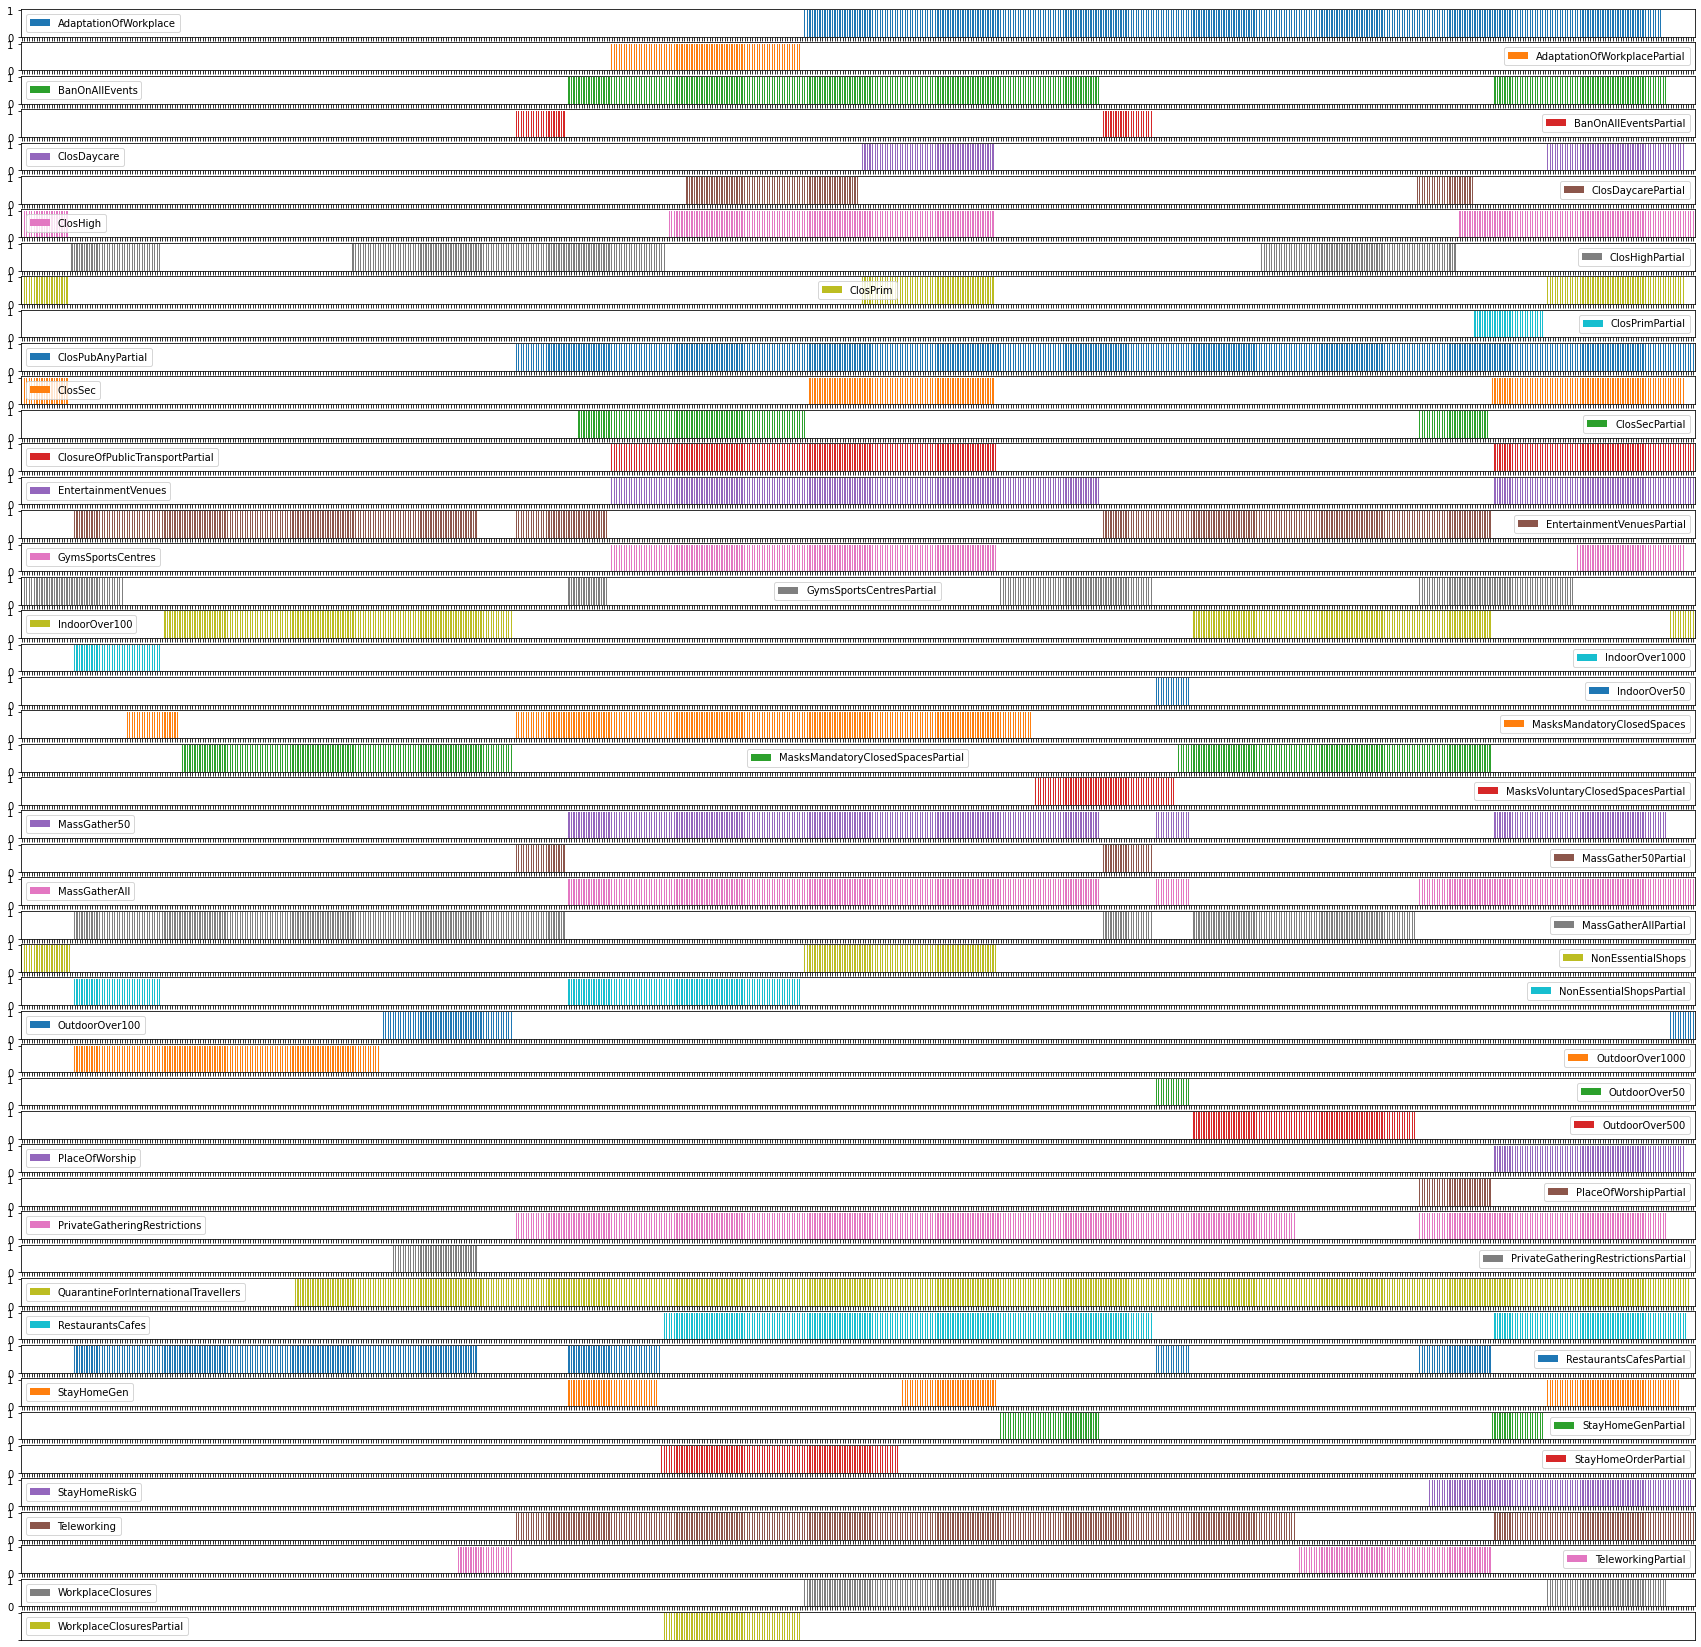

In [10]:
import matplotlib.pyplot as plt

test = measure_timeline_neth_train.sort_values(by='date', ascending = False)
test.to_csv('test.csv')
test = test.drop(columns = ['date'])

fig = plt.figure()
fig.set_size_inches(30, 10)

test.plot(kind= 'bar', subplots=True, figsize = (30,30), use_index = False, title =['','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','',])
plt.tick_params(
    axis='both',       # changes apply to the both axes
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False, # labels along the bottom edge are off
    labelleft=False    # labels along the left edge are off
) 

plt.xticks(ticks = None, labels = None)
plt.legend(loc='center left')
plt.show()

Now that we have our restrictions calendar in place and clear, let's bring in the mobility data from Google.

For this we will need to write our query in SQL, which will be passed to the Google cloud warehouse and retrieve the data we are looking for. Then, we will save the relevant information in a dataframe for it's further manipulation and analysis.

On a first check, let's have a look at how the mobility has changed, in average, in the different regions of the netherlands between today and the date the first measure was implemented in The Netherlands (2020-3-12).

In [11]:
# We will use the bigquery python integration with google cloud
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/leonardojulcamargo/corded-terrain-338710-8a9d6e2f3b9c.json"


from google.cloud import bigquery

client = bigquery.Client()

#Now we can query directly with SQL from our notebook
query = """
/*Declaring first query which retrieves the avg mobility changes for the whole Netherlands*/   

    WITH Netherlands_avg AS(
        SELECT  date,
                AVG(grocery_and_pharmacy_percent_change_from_baseline) AS Grocery_and_pharmacy_Neth,
                AVG(retail_and_recreation_percent_change_from_baseline) AS Retail_and_recreation_Neth,
                AVG(parks_percent_change_from_baseline) AS Parks_Neth,
                AVG(transit_stations_percent_change_from_baseline) AS Transit_stations_Neth,
                AVG(workplaces_percent_change_from_baseline) AS Workplaces_Neth,
                AVG(residential_percent_change_from_baseline) AS Residential_Neth,
        FROM `bigquery-public-data.covid19_google_mobility_eu.mobility_report`
        WHERE country_region = 'Netherlands' AND 
              date >= '2020-03-12' AND 
              sub_region_1 != 'None'
        GROUP BY 1
        ORDER BY date),
        
/*Declaring second query which retrieves the avg mobility changes per province*/           
        Provinces_avg AS(
        SELECT  date,
                sub_region_1,
                AVG(grocery_and_pharmacy_percent_change_from_baseline) AS Grocery_and_pharmacy,
                AVG(retail_and_recreation_percent_change_from_baseline) AS Retail_and_recreation,
                AVG(parks_percent_change_from_baseline) AS Parks,
                AVG(transit_stations_percent_change_from_baseline) AS Transit_stations,
                AVG(workplaces_percent_change_from_baseline) AS Workplaces,
                AVG(residential_percent_change_from_baseline) AS Residential,
        FROM `bigquery-public-data.covid19_google_mobility_eu.mobility_report`
        WHERE country_region = 'Netherlands' AND 
              date >= '2020-03-12' AND 
              sub_region_1 != 'None'
        GROUP BY 1, 2
        ORDER BY date, sub_region_1)
 
 /*Main query to retrieve all aggregations into one joint table*/   
    SELECT N.date,
           P.sub_region_1 Province,
           P.Grocery_and_pharmacy,
           P.Retail_and_recreation,
           P.Parks,
           P.Transit_stations,
           P.Workplaces,
           P.Residential,
           N.Grocery_and_pharmacy_Neth,
           N.Retail_and_recreation_Neth,
           N.Parks_Neth,
           N.Transit_stations_Neth,
           N.Workplaces_Neth,
           N.Residential_Neth
    FROM Provinces_avg P
    JOIN Netherlands_avg N
    ON P.date = N.date
    ORDER BY DATE
        
        """
mobility_data_raw = client.query(query).result().to_dataframe()

mobility_data_raw.head(2)

date Province  Grocery_and_pharmacy  Retail_and_recreation  Parks  \
0  2020-03-12  Drenthe             14.222222              -3.000000  -7.75   
1  2020-03-12  Zeeland             14.428571              -4.666667  13.80   

   Transit_stations  Workplaces  Residential  Grocery_and_pharmacy_Neth  \
0              -6.5    2.846154          2.0                  13.448413   
1              -6.0    0.307692          2.9                  13.448413   

   Retail_and_recreation_Neth  Parks_Neth  Transit_stations_Neth  \
0                   -6.215859       -3.95             -11.086758   
1                   -6.215859       -3.95             -11.086758   

   Workplaces_Neth  Residential_Neth  
0        -2.340369          3.333333  
1        -2.340369          3.333333

We will now process the incoming mobility data so we can easily display and work with it.

In [12]:
#Retrieving list of provinces from the incoming data
province_names = pd.unique(mobility_data_raw['Province'])

#Setting the date column to the right format
mobility_data_raw['date'] = pd.to_datetime(mobility_data_raw['date'])

#Trimming dates 
#mobility_data_raw_train = mobility_data_raw.drop(mobility_data_raw[mobility_data_raw.date > '2022-01-07'].index)

#Creating a separate dataframe for each province, including the global Netherlands averages for comparison
mobility_data = {}

for province in province_names:
    mobility_data[province] = mobility_data_raw[mobility_data_raw['Province'] ==  province].drop(['Province'], axis = 1).reset_index(drop = True)
    
#Let's also have one separate dataframe in our collection for the global Netherlands Data only:

mobility_data['Netherlands'] = mobility_data['Limburg'].drop(['Grocery_and_pharmacy', 'Retail_and_recreation', 'Parks', 'Transit_stations', 'Workplaces', 'Residential'], axis = 1)

#Creating a dataframe collection to train the ML model

mobility_data_train = mobility_data

#mobility_data_train['Netherlands'] = mobility_data_train['Netherlands'].drop(mobility_data_train['Netherlands'][mobility_data_train['Netherlands'].date > '2022-01-07'].index)



for province in mobility_data_train:
    mobility_data_train[province] = mobility_data_train[province].drop(mobility_data_train[province][mobility_data_train[province].date > '2022-01-07'].index)


mobility_data_train['Netherlands'].tail()


date  Grocery_and_pharmacy_Neth  Retail_and_recreation_Neth  \
662 2022-01-03                  12.559322                  -30.633721   
663 2022-01-04                  11.932773                  -35.245902   
664 2022-01-05                   4.181102                  -40.717703   
665 2022-01-06                  10.172691                  -36.231481   
666 2022-01-07                   4.072727                  -45.032389   

     Parks_Neth  Transit_stations_Neth  Workplaces_Neth  Residential_Neth  
662   14.878788             -50.495868       -45.720513         14.539683  
663    2.841270             -52.280488       -44.143590         15.006349  
664  -11.438356             -51.082305       -41.730769         13.944984  
665   19.058824             -48.785124       -42.202564         14.434505  
666  -11.585859             -48.341564       -39.671795         14.337748

Let's quickly visualize the changes in the workplace mobility from our just retrieved data

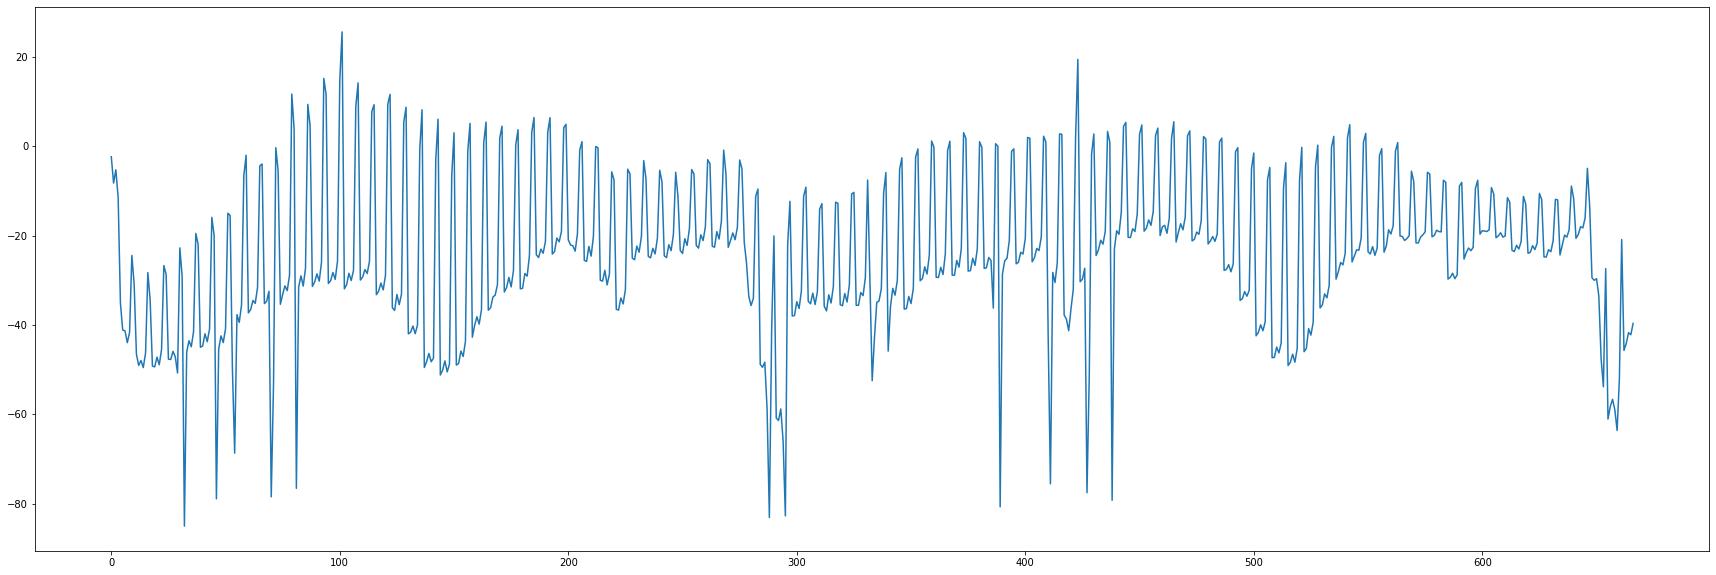

In [13]:
fig2 = plt.figure()
fig2.set_size_inches(30, 10)

plt.plot(mobility_data['Netherlands']['Workplaces_Neth'], figure = fig2)

# Finding relationships
In the next section, we will explore the relationship between the measures applied by the gonvernment and the mobility on different areas.

For this, we will apply the random forests algorithm to the combined data and see how well the population mobility can be predicted given a certain set of measures.

The first step will be to merge all the data collected and cleaned so far in just on dataframe so that the algorythms can operate.

In the next cells we will implement a random forests regressor to attempt to predict the population's behaviour based on the covid-19 measures implemented by the government in the Netherlands.

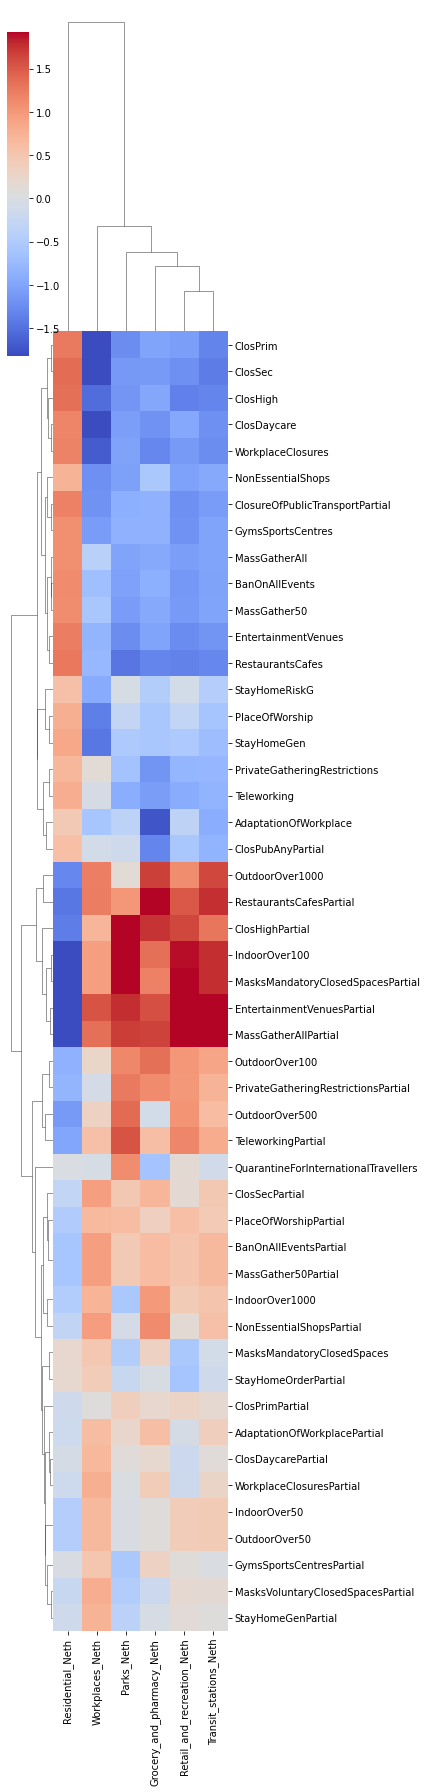

In [15]:
mobility_data['Netherlands'].set_index('date')


combined_df = pd.merge(mobility_data['Netherlands'],measure_timeline_neth_train, how='inner')
combined_df_corr = combined_df.corr()
cols_c = combined_df.columns.tolist()
combined_df_corr = combined_df_corr.drop(cols_c[7:], axis = 1) 
combined_df_corr = combined_df_corr.drop(cols_c[1:7], axis = 0)

#plotting the correlation heatmap
import seaborn as sns

sns.clustermap(combined_df_corr, cmap = 'coolwarm', robust = True, figsize=(6,25), metric="euclidean", z_score=1)
plt.show()

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split


mobility_features = measure_timeline_neth_train.columns.tolist()
mobility_features.pop(0)

#Choosing our features
X = measure_timeline_neth_train[mobility_features]

mobility_target = mobility_data['Netherlands'].columns.tolist()

mobility_target.pop(0)

#Choosing our predicted values
y = mobility_data['Netherlands'][mobility_target]

#mobility_data['Netherlands'].tail()

#measure_timeline_neth.tail(50)

#Splitting the data for the different predicted values
train_X = {}
val_X= {}
train_y = {}
val_y = {}
val_predictions = {}

for i in y:
    train_X[i], val_X[i], train_y[i], val_y[i] = train_test_split(X, y[i], random_state = 0)

#Creating our regressor
Netherlands_model = RandomForestRegressor(random_state = 1)

#Fitting and predicting mobility changes based on the provided data
for i in y:
    Netherlands_model.fit(train_X[i], train_y[i])

    val_predictions[i] = Netherlands_model.predict(val_X[i])
    print(f"{mean_absolute_error(val_y[i], val_predictions[i])}  {i}")


6.171235393945642  Grocery_and_pharmacy_Neth
6.8170426190602615  Retail_and_recreation_Neth
21.47784747595455  Parks_Neth
5.753274954350184  Transit_stations_Neth
10.78787656911996  Workplaces_Neth
2.3439658415497044  Residential_Neth
